# 06 — CNN Transfer Learning (MobileNetV2)

Obiettivo: migliorare la baseline CNN usando **transfer learning**.

Pipeline:
1. Carichiamo gli split dal DB (`train/val/test`).
2. Costruiamo `tf.data.Dataset` on-the-fly con resize+normalizzazione (+augmentation solo sul train).
3. Usiamo una rete pre-addestrata (ImageNet) come estrattore di feature.
4. (Opzionale) Fine-tuning degli ultimi layer.

> Nota: questo notebook usa i moduli in `src/garbagecls` (`db.py`, `paths.py`, `dataset.py`).

#### 0) Import + setup path + moduli src

In [1]:
import os
import sys
from pathlib import Path
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- setup path: notebook sta in /notebooks -> root = parent ---
PROJECT_ROOT = Path.cwd().parent
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("TensorFlow:", tf.__version__)

from garbagecls.db import load_env, read_images_df, split_dfs
from garbagecls.dataset import build_label_maps, make_dataset


PROJECT_ROOT: c:\Users\simon\Documents\VSC\Progetto-Data-Science
TensorFlow: 2.20.0


#### 1) Carico i dati dal DB e preparo label_id con visulizzazione di prova

In [2]:
load_env()  # legge .env

df = read_images_df(source="raw_flat")  # oppure None se vuoi tutto
df_train, df_val, df_test = split_dfs(df)

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))
df_train.head()

label2id, id2label = build_label_maps(df["label"].unique())

for d in (df_train, df_val, df_test):
    d["label_id"] = d["label"].map(label2id).astype("int32")

num_classes = len(label2id)
print("Classes:", num_classes, label2id, '\n')

print(df_train.head())


Train: 1768 Val: 379 Test: 380
Classes: 6 {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5} 

   image_id                                  filepath      label  split  \
0         1       data/raw_flat/plastic/plastic92.jpg    plastic  train   
1         2  data/raw_flat/cardboard/cardboard305.jpg  cardboard  train   
2         3   data/raw_flat/cardboard/cardboard53.jpg  cardboard  train   
3         4   data/raw_flat/cardboard/cardboard42.jpg  cardboard  train   
4         5          data/raw_flat/metal/metal141.jpg      metal  train   

   width  height  channels    source  label_id  
0    512     384         3  raw_flat         4  
1    512     384         3  raw_flat         0  
2    512     384         3  raw_flat         0  
3    512     384         3  raw_flat         0  
4    512     384         3  raw_flat         2  


c:\Users\simon\Documents\VSC\Progetto-Data-Science\src\garbagecls\db.py:77: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(base_query, conn, params=params if params else None)


#### 2) Creo i `tf.data.dataset` "raw" dai dataframe precedentemente creati  
Uso `make_dataset`:
- prende filepath e label_id
- legge file, decode, resize, normalizza [0,1] e applica augment solo su train

In [3]:
SEED = 42
BATCH_SIZE = 32
IMG_SIZE = (192, 256)  # (H, W) -> più leggero di 384x512

train_ds = make_dataset(
    df_train, training=True,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=True
)

val_ds = make_dataset(
    df_val, training=False,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=False
)

test_ds = make_dataset(
    df_test, training=False,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=False
)

(train_ds, val_ds, test_ds)


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

#### 3) Preprocessing specifico per MobileNetV2  
In particolare `preprocess_input` di MobileNetV2 si aspetta pixel in [0,255] e li trasforma in [-1,1]

In [4]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def mnv2_preprocess(x, y):
    x = preprocess_input(x * 255.0) # li riporto a [0,255] come si aspetta mobilenet
    return x, y

train_ds_mnv2 = train_ds.map(mnv2_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_mnv2   = val_ds.map(mnv2_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_mnv2  = test_ds.map(mnv2_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_mnv2


<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### 4) Costruzione modello (backbone + head)  
La **base** è la CNN pre-addestrata su ImageNet. A partire da questa che non modifico (base-trainable = False) tolgo la parte finale (include_top=False)

In [5]:
# backbone pre-addestrato
base = keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base.trainable = False  # fase 1: solo head

inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()


C:\Users\simon\AppData\Local\Temp\ipykernel_28312\3896276519.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = keras.applications.MobileNetV2(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 6, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### 5) Training "head-only"  
Di fatto alleno solo i pesi di Dense finale perchè GAP (global_average_pooling) e dropout non hanno pesi

In [6]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
]

history_head = model.fit(
    train_ds_mnv2,
    validation_data=val_ds_mnv2,
    epochs=10,
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(test_ds_mnv2, verbose=1)
print()
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 407ms/step - accuracy: 0.4989 - loss: 1.2951 - val_accuracy: 0.7150 - val_loss: 0.8112
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 394ms/step - accuracy: 0.7296 - loss: 0.7173 - val_accuracy: 0.7493 - val_loss: 0.6650
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 402ms/step - accuracy: 0.7862 - loss: 0.5880 - val_accuracy: 0.7863 - val_loss: 0.5973
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 398ms/step - accuracy: 0.8133 - loss: 0.5345 - val_accuracy: 0.8127 - val_loss: 0.5760
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - accuracy: 0.8264 - loss: 0.4756 - val_accuracy: 0.8179 - val_loss: 0.5430
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - accuracy: 0.8473 - loss: 0.4263 - val_accuracy: 0.8179 - val_loss: 0.5558
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 385ms/step - accuracy: 0.8569 - loss: 0.4072 - val_accuracy: 0.8364 - val_loss: 0.5399
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - accuracy: 0.8648 - loss: 0.3883 - val_accu

Salvo il modello (con relative informazioni)

In [7]:
models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(exist_ok=True)

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = models_dir / f"cnn_transfer_mnv2_head_{stamp}.keras"
model.save(model_path)

print("Saved model to:", model_path)

import json

info = {
  "model_type": "head_only",
  "img_size": IMG_SIZE,
  "batch_size": BATCH_SIZE,
  "seed": SEED,
  "val_acc_last": float(history_head.history["val_accuracy"][-1]),
  "test_acc": float(test_acc),
}

with open(models_dir / f"cnn_transfer_mnv2_head_{stamp}.json", "w") as f:
    json.dump(info, f, indent=2)


Saved model to: c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_transfer_mnv2_head_20260203-201637.keras


#### 6) Fine-tuning (sblocco parziale)  
Solo ora permettiamo al backbone di "aggiustarsi" leggermente sul nostro dataset, in modo molto leggero e controllato

In [8]:
base.trainable = True

# congela BatchNorm
for layer in base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# sblocca solo gli ultimi N layer del backbone
N = 30
for layer in base.layers[:-N]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_ft = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True),
]

history_ft = model.fit(
    train_ds_mnv2,
    validation_data=val_ds_mnv2,
    epochs=5,
    callbacks=callbacks_ft
)

test_loss, test_acc = model.evaluate(test_ds_mnv2, verbose=1)
print()
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")


Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 431ms/step - accuracy: 0.8665 - loss: 0.3721 - val_accuracy: 0.8391 - val_loss: 0.5065
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 406ms/step - accuracy: 0.8790 - loss: 0.3178 - val_accuracy: 0.8311 - val_loss: 0.5165
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 404ms/step - accuracy: 0.8903 - loss: 0.3153 - val_accuracy: 0.8417 - val_loss: 0.4993
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 410ms/step - accuracy: 0.8920 - loss: 0.2957 - val_accuracy: 0.8417 - val_loss: 0.4771
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 410ms/step - accuracy: 0.9118 - loss: 0.2560 - val_accuracy: 0.8443 - val_loss: 0.4836
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - accuracy: 0.8579 - loss: 0.4100

Test accuracy: 0.8579 | Test loss: 0.4100


Salvo il modello

In [9]:
models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(exist_ok=True)

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = models_dir / f"cnn_transfer_mnv2_finetune_{stamp}.keras"
model.save(model_path)

print("Saved model to:", model_path)

import json

info = {
  "model_type": "finetune",
  "img_size": IMG_SIZE,
  "batch_size": BATCH_SIZE,
  "seed": SEED,
  "val_acc_last": float(history_ft.history["val_accuracy"][-1]),
  "test_acc": float(test_acc),
}

with open(models_dir / f"cnn_transfer_mnv2_finetune_{stamp}.json", "w") as f:
    json.dump(info, f, indent=2)


Saved model to: c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_transfer_mnv2_finetune_20260203-201957.keras


#### CARICO MODELLO EVENTUALMENTE

In [ ]:
'''
from tensorflow import keras
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
models_dir = PROJECT_ROOT / "models"

model_path = models_dir / "cnn_transfer_mnv2_finetune_20260203-181109.keras"  # esempio

print("Loading model from:", model_path)
model = keras.models.load_model(model_path)
model.summary()

print("Model loaded successfully.")
'''

Loading model from: c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_baseline_20260203-1531.keras


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 382, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 191, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 189, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 94, 126, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 92, 124, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 46, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 365056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    46,727,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,463,956 (535.83 MB)

 Trainable params: 46,821,318 (178.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 93,642,638 (357.22 MB)

Model loaded successfully.


#### 7) Valutazione + curve

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - accuracy: 0.8579 - loss: 0.4100
Test accuracy: 0.8579 | Test loss: 0.4100


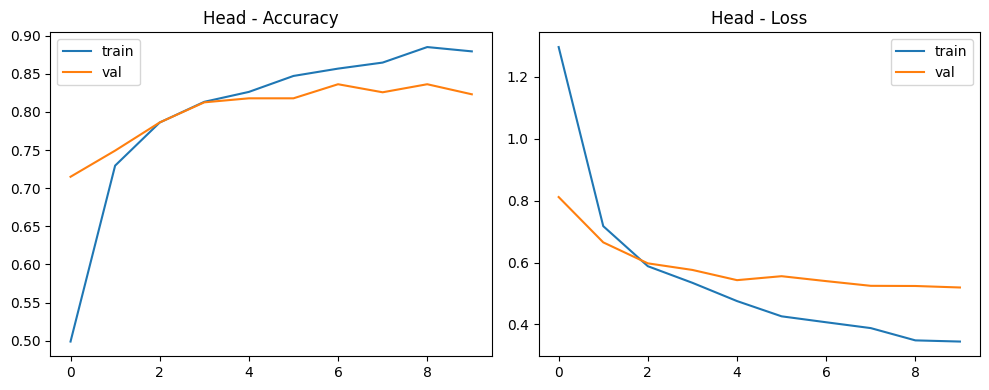

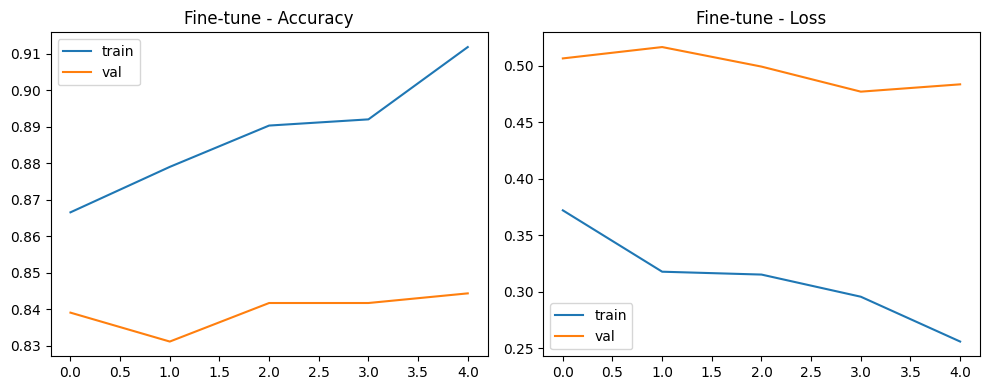

In [10]:
test_loss, test_acc = model.evaluate(test_ds_mnv2, verbose=1)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# curve training
def plot_history(h, title_prefix=""):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(h.history["accuracy"], label="train")
    plt.plot(h.history["val_accuracy"], label="val")
    plt.title(f"{title_prefix}Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h.history["loss"], label="train")
    plt.plot(h.history["val_loss"], label="val")
    plt.title(f"{title_prefix}Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history_head, "Head - ")
if "history_ft" in globals():
    plot_history(history_ft, "Fine-tune - ")


#### 8) Report + confusion matrix

              precision    recall  f1-score   support

   cardboard     0.8833    0.8833    0.8833        60
       glass     0.8592    0.8026    0.8299        76
       metal     0.8358    0.9032    0.8682        62
       paper     0.8901    0.9101    0.9000        89
     plastic     0.8077    0.8630    0.8344        73
       trash     0.9231    0.6000    0.7273        20

    accuracy                         0.8579       380
   macro avg     0.8665    0.8271    0.8405       380
weighted avg     0.8599    0.8579    0.8565       380



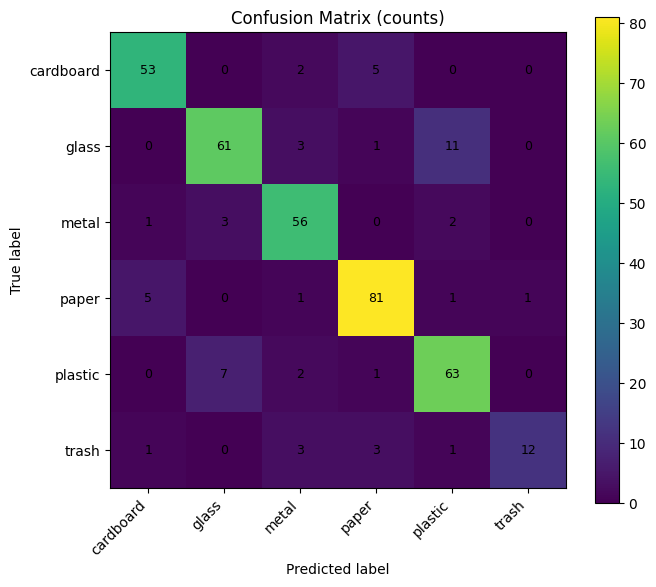

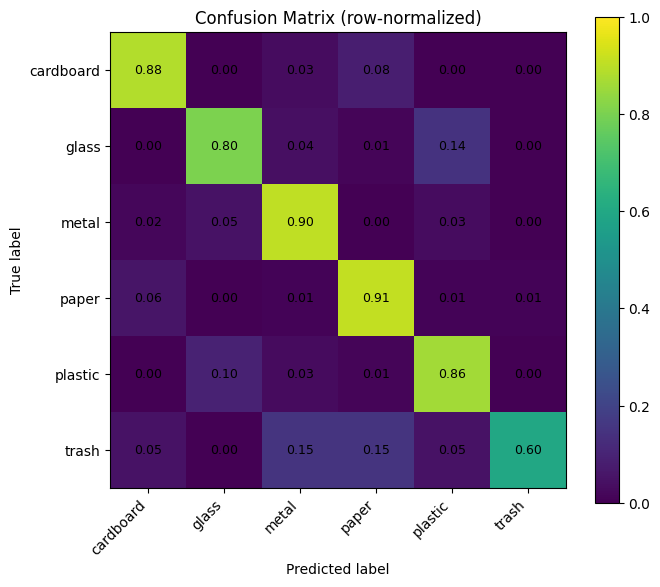

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

y_true, y_pred = [], []

for x_batch, y_batch in test_ds_mnv2:
    probs = model.predict(x_batch, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(preds.tolist())

labels = [id2label[i] for i in range(num_classes)]

print(classification_report(y_true, y_pred, target_names=labels, digits=4))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (counts)")
plt.colorbar()
plt.xticks(range(num_classes), labels, rotation=45, ha="right")
plt.yticks(range(num_classes), labels)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=9)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# row-normalized
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-9)
plt.figure(figsize=(7,6))
plt.imshow(cm_norm, interpolation="nearest", vmin=0, vmax=1)
plt.title("Confusion Matrix (row-normalized)")
plt.colorbar()
plt.xticks(range(num_classes), labels, rotation=45, ha="right")
plt.yticks(range(num_classes), labels)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", fontsize=9)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()
